---
title: "Selection Bias & Missing Data Challenge - Part 1"
subtitle: "Blue Noise Stippling: Creating Art from Data"
format:
  html: default
  pdf: default
execute:
  echo: true
  eval: true
---

# 🎨 Selection Bias & Missing Data Challenge - Part 1

::: {.callout-important}
## 📊 Challenge Requirements

**Your Task:** Reproduce the blue noise stippling process demonstrated below to create:
1. A stippled version of your chosen image
2. A progressive stippling GIF animation
3. Post both to a GitHub Pages site with appropriate captions and a brief explanation

**Part 2 Preview:** On November 18th, we'll tackle Part 2 of this challenge, where you'll create a statistical meme about selection bias and missing data using your stippled images.
:::

## The Problem: Can Algorithms Create Art?

**Core Question:** How can we convert a photograph into an aesthetically pleasing pattern of dots that preserves the visual information of the original image?

**The Challenge:** Blue noise stippling is a technique that converts images into patterns of dots (stipples) using algorithms that balance visual accuracy with spatial distribution. This challenge asks you to implement a modified "void and cluster" algorithm that combines importance sampling with blue noise distribution properties to create stippling patterns that are both visually accurate and spatially well-distributed.

**Our Approach:** We'll use a modified void-and-cluster algorithm that:
1. Creates an importance map identifying visually important regions
2. Uses a toroidal (periodic) Gaussian kernel for repulsion to ensure blue noise properties
3. Iteratively selects points with minimum energy
4. Balances image content importance with blue noise spatial distribution

::: {.callout-warning}
## ⚠️ AI Partnership Required

This challenge pushes boundaries intentionally. You'll tackle problems that normally require weeks of study, but with Cursor AI as your partner (and your brain keeping it honest), you can accomplish more than you thought possible.

**The new reality:** The four stages of competence are Ignorance → Awareness → Learning → Mastery. AI lets us produce Mastery-level work while operating primarily in the Awareness stage. I focus on awareness training, you leverage AI for execution, and together we create outputs that used to require years of dedicated study.
:::

## Introduction to Blue Noise Stippling

Blue noise stippling is a technique for converting images into a pattern of dots (stipples) that preserves the visual information of the original image while creating an aesthetically pleasing, evenly distributed pattern. This method follows the approach described by [Bart Wronski](https://bartwronski.com/2022/08/31/progressive-image-stippling-and-greedy-blue-noise-importance-sampling/).

The method uses a modified "void and cluster" algorithm that combines importance sampling with blue noise distribution properties to create stippling patterns that are both visually accurate and spatially well-distributed. This version uses **smooth extreme downweighting** that selectively downweights very dark and very light tones while preserving mid-tones, creating a more balanced distribution of stipples across the image.

## Loading the Original Image

First, let's load an image that we'll convert to a blue noise stippling pattern. You can use any image you'd like, but we'll demonstrate with the provided example.

::: {.panel-tabset}

### Python

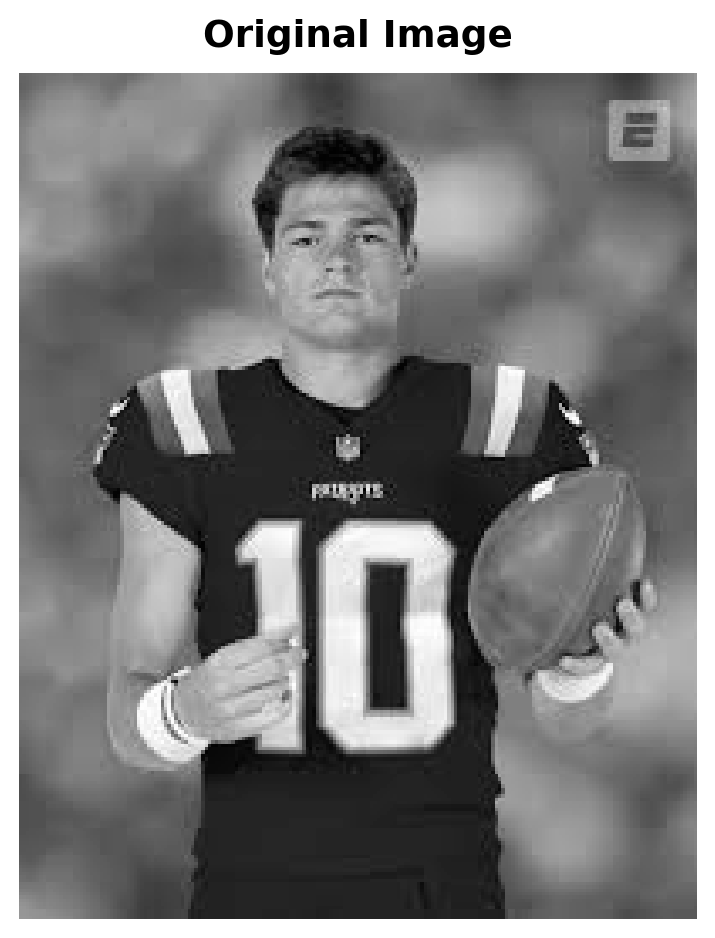

Image shape: (251, 201)
Image size: 251x201 pixels


In [1]:
#| label: load-image
#| echo: true
#| fig-cap: Original image before stippling

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = 'maye.jpeg'
original_img = Image.open(img_path)

# Convert to grayscale if needed
if original_img.mode != 'L':
    original_img = original_img.convert('L')

# Convert to numpy array and normalize to [0, 1]
img_array = np.array(original_img, dtype=np.float32) / 255.0

# Display the original image
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.imshow(img_array, cmap='gray', vmin=0, vmax=1)
ax.axis('off')
ax.set_title('Original Image', fontsize=14, fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

print(f"Image shape: {img_array.shape}")
print(f"Image size: {img_array.shape[0]}x{img_array.shape[1]} pixels")

## Importance Mapping

Before applying the stippling algorithm, we create an **importance map** that identifies which regions of the image should receive more stipples. The importance map is computed by:

- **Brightness inversion**: The image brightness is inverted so that dark areas receive higher importance and thus more dots, while light areas receive fewer dots
- **Extreme tone downweighting**: Smooth Gaussian functions downweight tones below 0.2 (very dark) and above 0.8 (very light), creating a gradual transition that preserves mid-tones
- **Mid-tone boost**: A smooth Gaussian function centered on mid-tones provides a gradual increase in importance for mid-tone regions, ensuring they receive appropriate stippling density
- **Selective and effective**: This approach ensures that stipples are distributed appropriately (more dots in dark areas and mid-tones, fewer in extreme dark/light areas) while maintaining good spatial distribution

::: {.panel-tabset}

### Python

In [2]:
#| label: importance-map
#| echo: true
#| warning: false

def compute_importance(
    gray_img: np.ndarray,
    extreme_downweight: float = 0.5,
    extreme_threshold_low: float = 0.4,
    extreme_threshold_high: float = 0.8,
    extreme_sigma: float = 0.1,
    mid_tone_boost: float = 0.4,
    mid_tone_sigma: float = 0.2,
):
    """
    Importance map computation that downweights extreme tones (very dark and very light)
    using smooth functions, while boosting mid-tones.
    
    Parameters
    ----------
    gray_img : np.ndarray
        Grayscale image in [0, 1]
    extreme_downweight : float
        Strength of downweighting for extreme tones (0.0 = no downweighting, 1.0 = maximum downweighting)
    extreme_threshold_low : float
        Threshold below which tones are considered "very dark" and get downweighted
    extreme_threshold_high : float
        Threshold above which tones are considered "very light" and get downweighted
    extreme_sigma : float
        Width of the smooth transition for extreme downweighting (smaller = sharper transition)
    mid_tone_boost : float
        Strength of mid-tone emphasis (0.0 = no boost, 1.0 = strong boost)
    mid_tone_sigma : float
        Width of the mid-tone Gaussian bump (smaller = narrower, larger = wider)
    
    Returns
    -------
    importance : np.ndarray
        Importance map in [0, 1]; higher = more stipples (dark areas and mid-tones get higher importance)
    """
    I = np.clip(gray_img, 0.0, 1.0)
    
    # Invert brightness: dark areas should get more dots (higher importance)
    I_inverted = 1.0 - I
    
    # Create smooth downweighting mask for extreme tones
    # Downweight very dark regions (I < extreme_threshold_low)
    dark_mask = np.exp(-((I - 0.0) ** 2) / (2.0 * (extreme_sigma ** 2)))
    dark_mask = np.where(I < extreme_threshold_low, dark_mask, 0.0)
    if dark_mask.max() > 0:
        dark_mask = dark_mask / dark_mask.max()
    
    # Downweight very light regions (I > extreme_threshold_high)
    light_mask = np.exp(-((I - 1.0) ** 2) / (2.0 * (extreme_sigma ** 2)))
    light_mask = np.where(I > extreme_threshold_high, light_mask, 0.0)
    if light_mask.max() > 0:
        light_mask = light_mask / light_mask.max()
    
    # Combine both masks
    extreme_mask = np.maximum(dark_mask, light_mask)
    
    # Apply smooth downweighting
    importance = I_inverted * (1.0 - extreme_downweight * extreme_mask)
    
    # Add smooth gradual mid-tone boost (Gaussian centered on 0.65)
    mid_tone_center = 0.65
    mid_tone_gaussian = np.exp(-((I - mid_tone_center) ** 2) / (2.0 * (mid_tone_sigma ** 2)))
    if mid_tone_gaussian.max() > 0:
        mid_tone_gaussian = mid_tone_gaussian / mid_tone_gaussian.max()
    
    # Boost importance in mid-tone regions
    importance = importance * (1.0 + mid_tone_boost * mid_tone_gaussian)
    
    # Normalize to [0,1]
    m, M = importance.min(), importance.max()
    if M > m: 
        importance = (importance - m) / (M - m)
    return importance

## Blue Noise Stippling Algorithm

The stippling algorithm uses a modified void-and-cluster approach that:

1. Creates an importance map that identifies visually important regions
2. Initializes an energy field based on the importance map (higher importance → lower energy)
3. Uses a toroidal (periodic) Gaussian kernel for repulsion to ensure blue noise properties
4. Iteratively selects points with minimum energy
5. Adds Gaussian "splats" around selected points to prevent clustering
6. Balances image content importance with blue noise spatial distribution

::: {.panel-tabset}

### Python

In [3]:
#| label: stippling-functions
#| echo: true
#| warning: false

import numpy as np

def toroidal_gaussian_kernel(h: int, w: int, sigma: float):
    """
    Create a periodic (toroidal) 2D Gaussian kernel centered at (0,0).
    The toroidal property means the kernel wraps around at the edges,
    ensuring consistent repulsion behavior regardless of point location.
    """
    y = np.arange(h)
    x = np.arange(w)
    # Compute toroidal distances (minimum distance considering wrapping)
    dy = np.minimum(y, h - y)[:, None]
    dx = np.minimum(x, w - x)[None, :]
    # Compute Gaussian
    kern = np.exp(-(dx**2 + dy**2) / (2.0 * sigma**2))
    s = kern.sum()
    if s > 0:
        kern /= s  # Normalize
    return kern


def void_and_cluster(
    input_img: np.ndarray,
    percentage: float = 0.08,
    sigma: float = 0.9,
    content_bias: float = 0.9,
    importance_img: np.ndarray | None = None,
    noise_scale_factor: float = 0.1,
):
    """
    Generate blue noise stippling pattern from input image using a modified
    void-and-cluster algorithm with content-weighted importance.
    """
    I = np.clip(input_img, 0.0, 1.0)
    h, w = I.shape

    # Compute or use provided importance map
    if importance_img is None:
        importance = compute_importance(I)
    else:
        importance = np.clip(importance_img, 0.0, 1.0)

    # Create toroidal Gaussian kernel for repulsion
    kernel = toroidal_gaussian_kernel(h, w, sigma)

    # Initialize energy field: lower energy → more likely to be picked
    energy_current = -importance * content_bias

    # Stipple buffer: start with white background; selected points become black dots
    final_stipple = np.ones_like(I)
    samples = []

    # Helper function to roll kernel to an arbitrary position
    def energy_splat(y, x):
        """Get energy contribution by rolling the kernel to position (y, x)."""
        return np.roll(np.roll(kernel, shift=y, axis=0), shift=x, axis=1)

    # Number of points to select
    num_points = int(I.size * percentage)

    # Choose first point near center with minimal energy
    cy, cx = h // 2, w // 2
    r = min(20, h // 10, w // 10)
    ys = slice(max(0, cy - r), min(h, cy + r))
    xs = slice(max(0, cx - r), min(w, cx + r))
    region = energy_current[ys, xs]
    flat = np.argmin(region)
    y0 = flat // (region.shape[1]) + (cy - r)
    x0 = flat % (region.shape[1]) + (cx - r)

    # Place first point
    energy_current = energy_current + energy_splat(y0, x0)
    energy_current[y0, x0] = np.inf  # Prevent reselection
    samples.append((y0, x0, I[y0, x0]))
    final_stipple[y0, x0] = 0.0  # Black dot

    # Iteratively place remaining points
    for i in range(1, num_points):
        # Add exploration noise that decreases over time
        exploration = 1.0 - (i / num_points) * 0.5  # Decrease from 1.0 to 0.5
        noise = np.random.normal(0.0, noise_scale_factor * content_bias * exploration, size=energy_current.shape)
        energy_with_noise = energy_current + noise

        # Find position with minimum energy (with noise for exploration)
        pos_flat = np.argmin(energy_with_noise)
        y = pos_flat // w
        x = pos_flat % w

        # Add Gaussian splat to prevent nearby points from being selected
        energy_current = energy_current + energy_splat(y, x)
        energy_current[y, x] = np.inf  # Prevent reselection

        # Record the sample
        samples.append((y, x, I[y, x]))
        final_stipple[y, x] = 0.0  # Black dot

    return final_stipple, np.array(samples)

## Preparing the Working Image

Before generating the stippling pattern, we prepare the image by resizing if necessary and computing the importance map.

::: {.panel-tabset}

### Python

In [4]:
#| label: prep-image
#| echo: true
#| warning: false

# Resize image if it's too large for faster processing
max_size = 512
if img_array.shape[0] > max_size or img_array.shape[1] > max_size:
    scale = max_size / max(img_array.shape[0], img_array.shape[1])
    new_size = (int(img_array.shape[1] * scale), int(img_array.shape[0] * scale))
    img_resized_pil = original_img.resize(new_size, Image.Resampling.LANCZOS)
    if img_resized_pil.mode != 'L':
        img_resized_pil = img_resized_pil.convert('L')
    img_resized = np.array(img_resized_pil, dtype=np.float32) / 255.0
    print(f"Resized image from {img_array.shape} to {img_resized.shape} for processing")
else:
    img_resized = img_array.copy()

# Ensure img_resized is 2D grayscale
if len(img_resized.shape) > 2:
    img_resized = img_resized[:, :, 0]
elif len(img_resized.shape) == 2:
    pass
else:
    raise ValueError(f"Unexpected image shape: {img_resized.shape}")

print(f"Final image shape: {img_resized.shape} (should be 2D for grayscale)")

# Compute importance map using default parameters
importance_map = compute_importance(
    img_resized,
    extreme_downweight=0.5,
    extreme_threshold_low=0.2,
    extreme_threshold_high=0.8,
    extreme_sigma=0.1
)
print("Importance map computed")

Final image shape: (251, 201) (should be 2D for grayscale)
Importance map computed


## Generating the Stippled Image

Now let's apply the stippling algorithm to create the blue noise stippling pattern.

::: {.panel-tabset}

### Python

In [5]:
#| label: generate-stipple
#| echo: true
#| warning: false

# Generate stippling pattern
print("Generating blue noise stippling pattern...")
stipple_pattern, samples = void_and_cluster(
    img_resized,
    percentage=0.08,
    sigma=0.9,
    content_bias=0.9,
    importance_img=importance_map,
    noise_scale_factor=0.1
)

print(f"Generated {len(samples)} stipple points")
print(f"Stipple pattern shape: {stipple_pattern.shape}")

Generating blue noise stippling pattern...


Generated 4036 stipple points
Stipple pattern shape: (251, 201)


## Displaying the Results

Let's visualize the original image, the importance map, and the stippled version side by side for comparison.

::: {.panel-tabset}

### Python

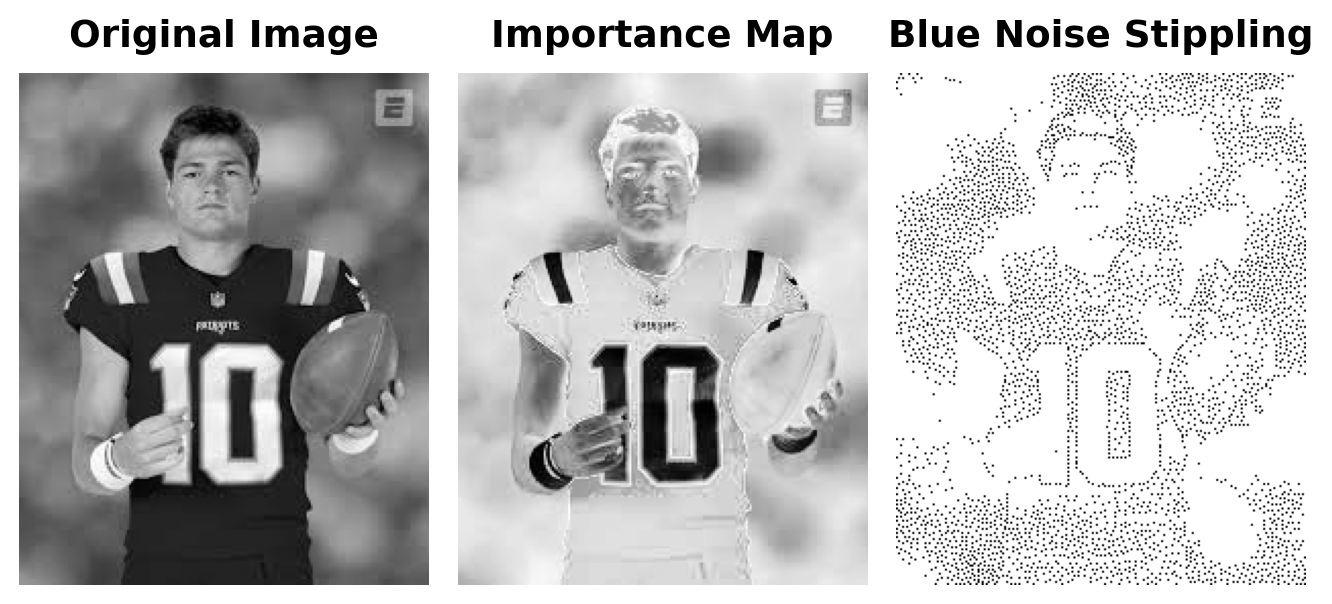

In [6]:
#| label: display-results
#| echo: true
#| fig-cap: Comparison of original image, importance map, and blue noise stippling

fig, axes = plt.subplots(1, 3, figsize=(7, 4))

# Display original image
axes[0].imshow(img_resized, cmap='gray', vmin=0, vmax=1)
axes[0].axis('off')
axes[0].set_title('Original Image', fontsize=14, fontweight='bold', pad=10)

# Display importance map
axes[1].imshow(importance_map, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Importance Map', fontsize=14, fontweight='bold', pad=10)

# Display stippled image
axes[2].imshow(stipple_pattern, cmap='gray', vmin=0, vmax=1)
axes[2].axis('off')
axes[2].set_title('Blue Noise Stippling', fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

## Progressive Stippling Animation

This section creates a GIF showing how the stippled image looks as more points are added sequentially. We'll use the already-computed stippling points to generate frames at increments of 100 points.

::: {.panel-tabset}

### Python

In [7]:
#| label: progressive-stippling
#| echo: true
#| warning: false

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

# Use the existing samples array from the already-computed stippling
print(f"Using existing stippling with {len(samples)} points")
print(f"Image shape: {img_resized.shape}")

# Create progressive frames by adding points sequentially
frame_increment = 100
frames = []
point_counts = []

# Start with white background
h, w = img_resized.shape
progressive_stipple = np.ones_like(img_resized)

# Add first point and save initial frame
if len(samples) > 0:
    y0, x0, intensity0 = int(samples[0, 0]), int(samples[0, 1]), samples[0, 2]
    progressive_stipple[y0, x0] = 0.0
    frames.append(progressive_stipple.copy())
    point_counts.append(1)

# Add remaining points sequentially and save frames at increments
for i in range(1, len(samples)):
    y, x = int(samples[i, 0]), int(samples[i, 1])
    progressive_stipple[y, x] = 0.0  # Add black dot
    
    # Save frame at increments (100, 200, 300, ...) and at the end
    if (i + 1) % frame_increment == 0 or i == len(samples) - 1:
        frames.append(progressive_stipple.copy())
        point_counts.append(i + 1)

print(f"Generated {len(frames)} frames")
print(f"Point counts: {point_counts}")

Using existing stippling with 4036 points
Image shape: (251, 201)
Generated 42 frames
Point counts: [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4036]


Now let's create the GIF animation:

::: {.panel-tabset}

### Python

Creating GIF animation...


GIF saved to: progressive_stippling.gif
Total frames: 42
Point counts: [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4036]


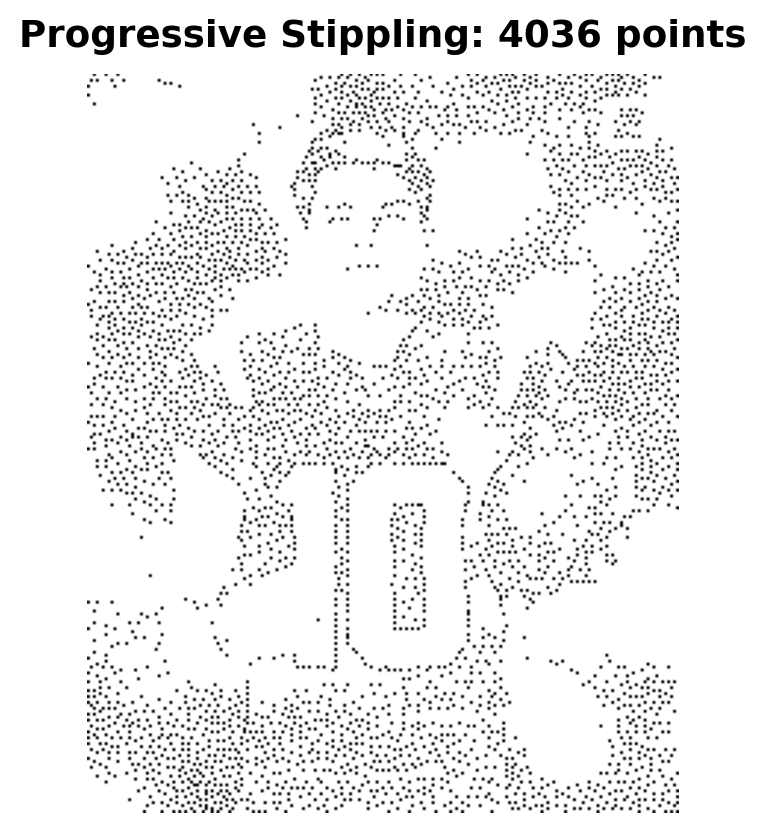

In [8]:
#| label: create-gif
#| include: false
#| fig-cap: Progressive stippling animation showing build-up of points
#| warning: false

# Create figure for animation
fig, ax = plt.subplots(figsize=(7, 5))
ax.axis('off')

# Create the animation
print("Creating GIF animation...")
writer = PillowWriter(fps=2)  # 2 frames per second

gif_path = 'progressive_stippling.gif'
with writer.saving(fig, gif_path, dpi=100):
    for i in range(len(frames)):
        ax.clear()
        ax.axis('off')
        ax.imshow(frames[i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'Progressive Stippling: {point_counts[i]} points', 
                     fontsize=14, fontweight='bold', pad=10)
        writer.grab_frame()

print(f"GIF saved to: {gif_path}")
print(f"Total frames: {len(frames)}")
print(f"Point counts: {point_counts}")

![Progressive stippling animation showing the sequential build-up of points. Each frame represents an increment of 100 points, demonstrating how the blue noise stippling pattern develops as more points are added.](progressive_stippling.gif)
